In [2]:
!pip install split_folders
import splitfolders
splitfolders.ratio("../input/state-farm-distracted-driver-detection/imgs/train", output="./", seed=1337, ratio=(.6, .2, .2), group_prefix=None) # default values

Copying files: 22424 files [03:54, 95.72 files/s] 


In [6]:
import pandas as pd
import numpy as np
import os
import keras
import matplotlib.pyplot as plt
from keras.layers import Dense, Dropout, Flatten, ZeroPadding2D, Conv2D, MaxPooling2D, Activation, GlobalAveragePooling2D
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, Sequential
#from keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils import class_weight


In [20]:
import os
NUM_CLASSES = len(os.listdir(r'./test'))

train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input) #included in our dependencies

train_generator=train_datagen.flow_from_directory(r'./train', # this is where you specify the path to the main data folder
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=24,
                                                 class_mode='categorical',
                                                 shuffle=True)

val_datagen=ImageDataGenerator(preprocessing_function=preprocess_input) #included in our dependencies

val_generator=val_datagen.flow_from_directory(r'./val', # this is where you specify the path to the main data folder
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=24,
                                                 class_mode='categorical',
                                                 shuffle=True)

Found 13451 images belonging to 10 classes.
Found 4481 images belonging to 10 classes.


In [10]:
from keras.models import model_from_json

# load json and create model
json_file = open('../input/models/MobileNet.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
mnet = model_from_json(loaded_model_json)
# load weights into new model
mnet.load_weights("../input/models/MobileNet.h5")

2022-10-08 19:43:38.342155: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-08 19:43:38.418686: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-08 19:43:38.419485: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-08 19:43:38.421363: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [12]:
from keras.models import model_from_json

# load json and create model
json_file = open('../input/densenet/densenet121.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
dnet = model_from_json(loaded_model_json)
# load weights into new model
dnet.load_weights("../input/densenet/densenet121.h5")

In [13]:
print(mnet.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 1024)              3228864   
_________________________________________________________________
dense (Dense)                (None, 10)                10250     
Total params: 3,239,114
Trainable params: 3,217,226
Non-trainable params: 21,888
_________________________________________________________________
None


In [14]:
print(dnet.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 1024)              7037504   
_________________________________________________________________
dense (Dense)                (None, 10)                10250     
Total params: 7,047,754
Trainable params: 6,964,106
Non-trainable params: 83,648
_________________________________________________________________
None


In [15]:
test_datagen=ImageDataGenerator(preprocessing_function=preprocess_input)
batch_size=24
pred_dir = r'./test'
test_generator = test_datagen.flow_from_directory(
    directory=pred_dir,
    target_size=(224,224),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode=None,
    shuffle=False
)

Found 4492 images belonging to 10 classes.


In [ ]:
pred=model.predict_generator(test_generator,verbose=1,steps=test_generator.n/batch_size)
​
predicted_class_indices=np.argmax(pred,axis=1)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]
filenames=test_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
print(results)
​

In [16]:
pred_m=mnet.predict_generator(test_generator,verbose=1,steps=test_generator.n/batch_size)
pred_d=dnet.predict_generator(test_generator,verbose=1,steps=test_generator.n/batch_size)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
2022-10-08 19:48:53.231525: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-10-08 19:48:54.622955: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


187/187 [==============================] - 27s 131ms/step


In [18]:
finalpred=(pred_m*0.7+pred_d*0.3)

In [21]:
predicted_class_indices=np.argmax(finalpred,axis=1)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]
filenames=test_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
print(results)

               Filename Predictions
0     c0/img_100026.jpg          c0
1     c0/img_100074.jpg          c0
2     c0/img_100312.jpg          c0
3     c0/img_100337.jpg          c0
4       c0/img_1005.jpg          c0
...                 ...         ...
4487    c9/img_9877.jpg          c9
4488   c9/img_99010.jpg          c9
4489   c9/img_99212.jpg          c9
4490   c9/img_99740.jpg          c9
4491   c9/img_99801.jpg          c9

[4492 rows x 2 columns]


In [23]:
import pandas as pd
t_counter = 0
f_counter = 0

file_arr = []
pred_arr = []

for index, row in results.iterrows():
    #print(row['Filename'].split('/')[0], row['Predictions'])
    file_arr.append(row['Filename'].split('/')[0])
    pred_arr.append(row['Predictions'])
    if row['Filename'].split('/')[0] == row['Predictions']:
        t_counter = t_counter + 1
    else:
        f_counter = f_counter + 1
print(t_counter, f_counter)

4482 10


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       499
           1       1.00      1.00      1.00       454
           2       1.00      1.00      1.00       464
           3       1.00      1.00      1.00       470
           4       1.00      1.00      1.00       466
           5       1.00      1.00      1.00       463
           6       1.00      1.00      1.00       465
           7       1.00      1.00      1.00       401
           8       1.00      0.99      0.99       383
           9       1.00      1.00      1.00       427

   micro avg       1.00      1.00      1.00      4492
   macro avg       1.00      1.00      1.00      4492
weighted avg       1.00      1.00      1.00      4492
 samples avg       1.00      1.00      1.00      4492

99.7773820124666
Class  0  Accuracy:  0.9979959919839679
Class  1  Accuracy:  1.0
Class  2  Accuracy:  1.0
Class  3  Accuracy:  0.997872340425532
Class  4  Accuracy:  0.9957081545064378
C

<AxesSubplot:>

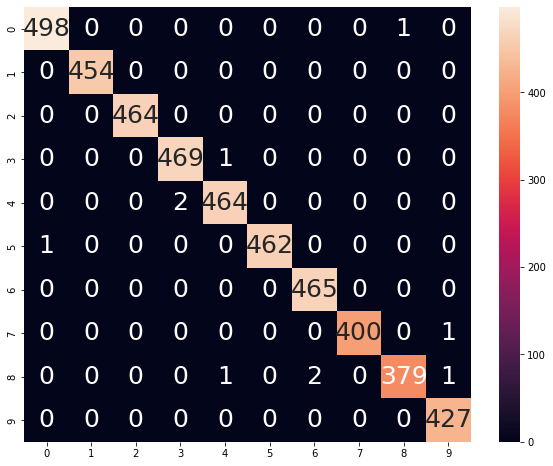

In [24]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
test_y = labelencoder.fit_transform(file_arr)
pred_y = labelencoder.fit_transform(pred_arr)
test_y_or = test_y
pred_y_or = pred_y

from keras.utils import np_utils
test_y = np_utils.to_categorical(test_y, NUM_CLASSES)
pred_y = np_utils.to_categorical(pred_y, NUM_CLASSES)
from sklearn.metrics import classification_report
print(classification_report(test_y, pred_y))

from sklearn.metrics import accuracy_score
score = accuracy_score(test_y, pred_y)
print(score*100)

from sklearn.metrics import confusion_matrix
c=confusion_matrix(test_y_or, pred_y_or)
x = c.diagonal()/c.sum(axis=1)
for i in range(len(x)):
    print('Class ', i, ' Accuracy: ', x[i])
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize = (10,8))
sns.heatmap(c, annot=True, annot_kws={"size": 25}, fmt='d')